In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model
%matplotlib inline

In [3]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/hist/'
thefiles = sorted(glob.glob(thedir+'*.h0.*nc'))
ds = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')
nmonths = len(ds.time)
yr0 = ds['time.year'][0].values
ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [4]:
params =['taulnir', 'dleaf', 'tkd_sand', 'bsw_sf', 'n_melt_coef', 'medlynslope', 
         'jmaxb1', 'kmax', 'dbh', 'grperc', 'FUN_fracfixers', 
         'froot_leaf', 'leaf_long', 'tau_cwd', 'k_nitr_max_perday', 'cli_scale', 'vcmaxha']

In [119]:
thedir = '/glade/scratch/djk2120/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000/run/'
thefile = glob.glob(thedir+'*.h0.*')[0]
base = xr.open_dataset(thefile)

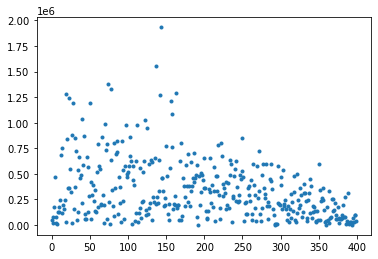

In [122]:
plt.plot(la,'.')

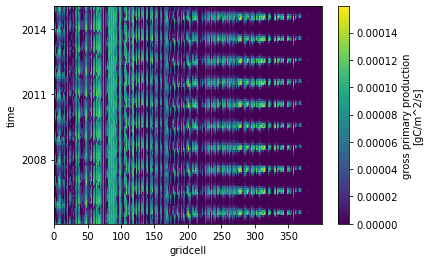

In [121]:
base.GPP.plot()

In [5]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [6]:
tmp = xr.open_dataset('sparsegrid_land_area.nc')
la  = tmp.landarea

In [117]:
max(la/landarea)

<xarray.DataArray 'landarea' ()>
array(262.32138367)

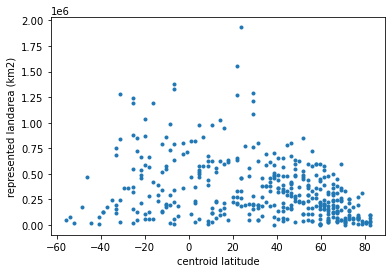

In [7]:
plt.plot(ds.grid1d_lat.sel(ens=0),la,'.')
plt.ylabel('represented landarea (km2)')
plt.xlabel('centroid latitude');

In [8]:
gpp_avg = 1e-9*(la*month_wts(10)*24*60*60/10*ds.GPP).sum(dim=['time','gridcell']).compute()

In [9]:
et_avg = 1/la.sum()*(4e-7*24*60*60/10*la*month_wts(10)*ds.EFLX_LH_TOT).sum(dim=['time','gridcell']).compute()

In [10]:
wue = gpp_avg/(1e-9*la.sum()*et_avg)

In [11]:
ix1 = [0,*3+2*np.arange(15)]
x1  = [1,*3+np.arange(15)]
ix2 = [1,*2+2*np.arange(16)]
x2  = 1+np.arange(17)

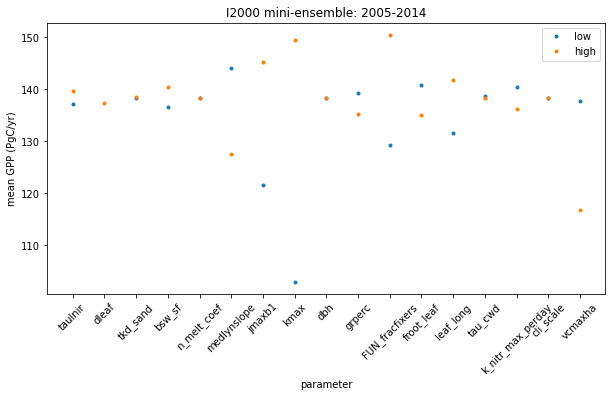

In [12]:
plt.figure(figsize=[10,5])
plt.plot(x1,gpp_avg[ix1],'.')
plt.plot(x2,gpp_avg[ix2],'.')
plt.xlabel('parameter')
plt.ylabel('mean GPP (PgC/yr)')
plt.xticks(1+np.arange(17),params,rotation = 45)
plt.title('I2000 mini-ensemble: 2005-2014')
plt.legend(['low','high']);

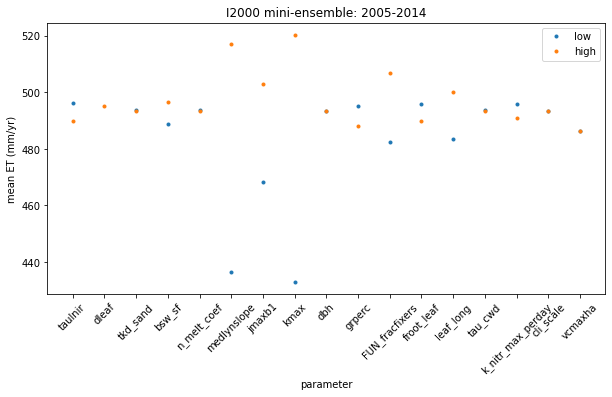

In [76]:
plt.figure(figsize=[10,5])
plt.plot(x1,et_avg[ix1],'.')
plt.plot(x2,et_avg[ix2],'.')
plt.xlabel('parameter')
plt.ylabel('mean ET (mm/yr)')
plt.xticks(1+np.arange(17),params,rotation = 45)
plt.title('I2000 mini-ensemble: 2005-2014')
plt.legend(['low','high']);

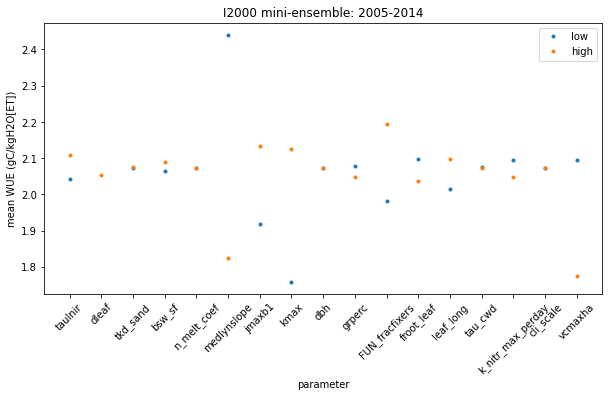

In [78]:
plt.figure(figsize=[10,5])
plt.plot(x1,wue[ix1],'.')
plt.plot(x2,wue[ix2],'.')
plt.xlabel('parameter')
plt.ylabel('mean WUE (gC/kgH2O[ET])')
plt.xticks(1+np.arange(17),params,rotation = 45)
plt.title('I2000 mini-ensemble: 2005-2014')
plt.legend(['low','high']);

In [13]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP3/'
thefiles = sorted(glob.glob(thedir+'*.h0.*nc'))
step3 = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')

In [14]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP4/'
thefiles = sorted(glob.glob(thedir+'*.h0.*nc'))
step4 = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')

In [102]:
ix = step3['time.year']>1
tvc_avg_step3 = step3.TOTVEGC.isel(time=ix).mean(dim=['gridcell']).compute()
ix = step4['time.year']>1
tvc_avg_step4 = step4.TOTVEGC.isel(time=ix).mean(dim=['gridcell']).compute()
mwts = month_wts(10)/365
tvc_avg_prod = (mwts*ds.TOTVEGC).groupby('time.year').sum().mean(dim='gridcell')

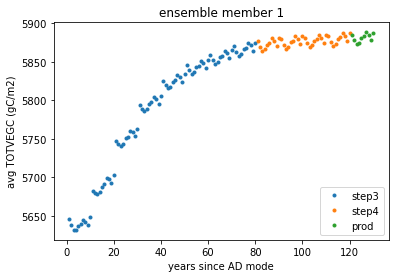

In [107]:
ee=0
plt.plot(1+np.arange(80),tvc_avg_step3.sel(ens=ee),'.')
plt.plot(81+np.arange(40),tvc_avg_step4.sel(ens=ee),'.')
plt.plot(121+np.arange(10),tvc_avg_prod.sel(ens=ee),'.')
plt.legend(['step3','step4','prod'],loc=4)
plt.title('ensemble member '+str(ee+1))
plt.xlabel('years since AD mode')
plt.ylabel('avg TOTVEGC (gC/m2)');

In [113]:
ix = step3['time.year']>1
tvc_tot_step3 = 1e-9*(la*step3.TOTVEGC.isel(time=ix)).sum(dim=['gridcell']).compute()
ix = step4['time.year']>1
tvc_tot_step4 = 1e-9*(la*step4.TOTVEGC.isel(time=ix)).sum(dim=['gridcell']).compute()
mwts = month_wts(10)/365
tvc_prod = 1e-9*(la*mwts*ds.TOTVEGC).groupby('time.year').sum().sum(dim='gridcell').compute()

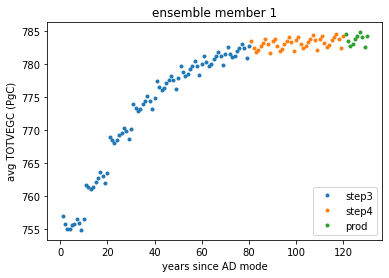

In [114]:
ee=0
plt.plot(1+np.arange(80),tvc_tot_step3.sel(ens=ee),'.')
plt.plot(81+np.arange(40),tvc_tot_step4.sel(ens=ee),'.')
plt.plot(121+np.arange(10),tvc_prod.sel(ens=ee),'.')
plt.legend(['step3','step4','prod'],loc=4)
plt.title('ensemble member '+str(ee+1))
plt.xlabel('years since AD mode')
plt.ylabel('avg TOTVEGC (PgC)');

In [54]:
ee = 0
dq = np.zeros(12);
for i in range(12):
    if i<7:
        ix1 = np.logical_and( step3['time.year']>1+10*i,step3['time.year']<=11+10*i)
        ix2 = np.logical_and(step3['time.year']>11+10*i,step3['time.year']<=21+10*i)
        x1  = step3.TOTECOSYSC.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = step3.TOTECOSYSC.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i==7:
        ix1 = np.logical_and( step3['time.year']>1+10*i,step3['time.year']<=11+10*i)
        ix2 = np.logical_and( step4['time.year']>1+10*(i-7),step4['time.year']<=11+10*(i-7))
        x1  = step3.TOTECOSYSC.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = step4.TOTECOSYSC.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i>7:
        ix1 = np.logical_and( step4['time.year']> 1+10*(i-8),step4['time.year']<=11+10*(i-8))
        ix2 = np.logical_and( step4['time.year']>11+10*(i-8),step4['time.year']<=21+10*(i-8))
        x1  = step4.TOTECOSYSC.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = step4.TOTECOSYSC.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i==11:
        ix = step4['time.year']>31
        x1 = step4.TOTECOSYSC.sel(ens=ee).isel(time=ix1).mean(dim='time')
        mwts = month_wts(10)/365
        x2 = (mwts*ds.TOTECOSYSC.sel(ens=ee)).groupby('time.year').sum().mean(dim='year')
        
    dtec  = x1-x2
    dq[i] = (abs(dtec)>10).sum()

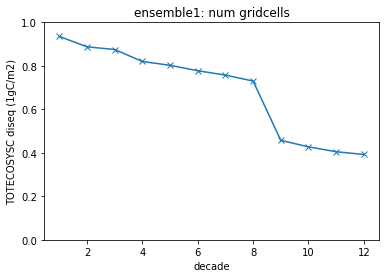

In [58]:
plt.plot(1+np.arange(12),dq/400,'-x')
plt.ylabel('TOTECOSYSC diseq (1gC/m2)')
plt.xlabel('decade')
plt.ylim([0,1])
plt.title('ensemble1: num gridcells');

In [63]:
ee = 0
dq = np.zeros(12);
for i in range(12):
    if i<7:
        ix1 = np.logical_and( step3['time.year']>1+10*i,step3['time.year']<=11+10*i)
        ix2 = np.logical_and(step3['time.year']>11+10*i,step3['time.year']<=21+10*i)
        x1  = step3.TOTECOSYSC.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = step3.TOTECOSYSC.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i==7:
        ix1 = np.logical_and( step3['time.year']>1+10*i,step3['time.year']<=11+10*i)
        ix2 = np.logical_and( step4['time.year']>1+10*(i-7),step4['time.year']<=11+10*(i-7))
        x1  = step3.TOTECOSYSC.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = step4.TOTECOSYSC.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i>7:
        ix1 = np.logical_and( step4['time.year']> 1+10*(i-8),step4['time.year']<=11+10*(i-8))
        ix2 = np.logical_and( step4['time.year']>11+10*(i-8),step4['time.year']<=21+10*(i-8))
        x1  = step4.TOTECOSYSC.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = step4.TOTECOSYSC.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i==11:
        ix = step4['time.year']>31
        x1 = step4.TOTECOSYSC.sel(ens=ee).isel(time=ix1).mean(dim='time')
        mwts = month_wts(10)/365
        x2 = (mwts*ds.TOTECOSYSC.sel(ens=ee)).groupby('time.year').sum().mean(dim='year')
        
    dtec  = x1-x2
    ixdq  = (abs(dtec)>10)
    dq[i] = la[ixdq].sum()/la.sum()

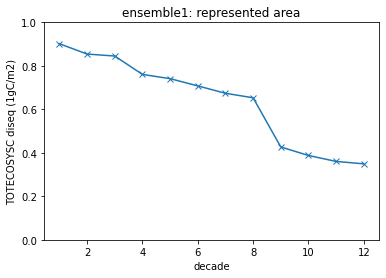

In [64]:
plt.plot(1+np.arange(12),dq,'-x')
plt.ylabel('TOTECOSYSC diseq (1gC/m2)')
plt.xlabel('decade')
plt.ylim([0,1])
plt.title('ensemble1: represented area');

In [70]:
ee = 0
dq = np.zeros(12);
for i in range(12):
    if i<7:
        ix1 = np.logical_and( step3['time.year']>1+10*i,step3['time.year']<=11+10*i)
        ix2 = np.logical_and(step3['time.year']>11+10*i,step3['time.year']<=21+10*i)
        tec = step3.TOTECOSYSC+step3.TOTSOMC_1m-step3.TOTSOMC
        x1  = tec.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = tec.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i==7:
        ix1 = np.logical_and( step3['time.year']>1+10*i,step3['time.year']<=11+10*i)
        ix2 = np.logical_and( step4['time.year']>1+10*(i-7),step4['time.year']<=11+10*(i-7))
        tec = step3.TOTECOSYSC+step3.TOTSOMC_1m-step3.TOTSOMC
        x1  = tec.sel(ens=ee).isel(time=ix1).mean(dim='time')
        tec = step4.TOTECOSYSC+step4.TOTSOMC_1m-step4.TOTSOMC
        x2  = tec.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i>7:
        ix1 = np.logical_and( step4['time.year']> 1+10*(i-8),step4['time.year']<=11+10*(i-8))
        ix2 = np.logical_and( step4['time.year']>11+10*(i-8),step4['time.year']<=21+10*(i-8))
        tec = step4.TOTECOSYSC+step4.TOTSOMC_1m-step4.TOTSOMC
        x1  = tec.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = tec.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i==11:
        ix = step4['time.year']>31
        tec = step4.TOTECOSYSC+step4.TOTSOMC_1m-step4.TOTSOMC
        x1 = tec.sel(ens=ee).isel(time=ix1).mean(dim='time')
        mwts = month_wts(10)/365
        tec = ds.TOTECOSYSC+ds.TOTSOMC_1m-ds.SOMC
        x2 = (mwts*tec.sel(ens=ee)).groupby('time.year').sum().mean(dim='year')
        
    dtec  = x1-x2
    ixdq  = (abs(dtec)>10)
    dq[i] = la[ixdq].sum()/la.sum()

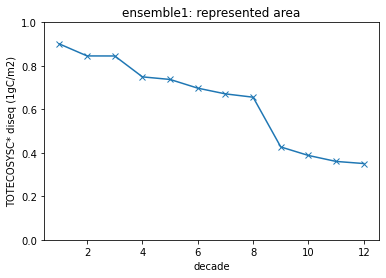

In [71]:
plt.plot(1+np.arange(12),dq,'-x')
plt.ylabel('TOTECOSYSC* diseq (1gC/m2)')
plt.xlabel('decade')
plt.ylim([0,1])
plt.title('ensemble1: represented area');

In [78]:
landarea = np.zeros([400])
ixy = step3['grid1d_ixy'].sel(ens=0).values
jxy = step3['grid1d_jxy'].sel(ens=0).values
k = -1
for i,j in zip(ixy,jxy):
    i = int(i)-1
    j = int(j)-1
    k +=1
    landarea[k] = step3['area'].sel(ens=0)[j,i]*step3['landfrac'].sel(ens=0)[j,i]

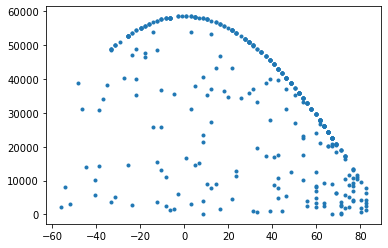

In [81]:
plt.plot(step3['grid1d_lat'].sel(ens=0).values,landarea,'.')

In [82]:
ee = 0
dq = np.zeros(12);
for i in range(12):
    if i<7:
        ix1 = np.logical_and( step3['time.year']>1+10*i,step3['time.year']<=11+10*i)
        ix2 = np.logical_and(step3['time.year']>11+10*i,step3['time.year']<=21+10*i)
        tec = step3.TOTECOSYSC+step3.TOTSOMC_1m-step3.TOTSOMC
        x1  = tec.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = tec.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i==7:
        ix1 = np.logical_and( step3['time.year']>1+10*i,step3['time.year']<=11+10*i)
        ix2 = np.logical_and( step4['time.year']>1+10*(i-7),step4['time.year']<=11+10*(i-7))
        tec = step3.TOTECOSYSC+step3.TOTSOMC_1m-step3.TOTSOMC
        x1  = tec.sel(ens=ee).isel(time=ix1).mean(dim='time')
        tec = step4.TOTECOSYSC+step4.TOTSOMC_1m-step4.TOTSOMC
        x2  = tec.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i>7:
        ix1 = np.logical_and( step4['time.year']> 1+10*(i-8),step4['time.year']<=11+10*(i-8))
        ix2 = np.logical_and( step4['time.year']>11+10*(i-8),step4['time.year']<=21+10*(i-8))
        tec = step4.TOTECOSYSC+step4.TOTSOMC_1m-step4.TOTSOMC
        x1  = tec.sel(ens=ee).isel(time=ix1).mean(dim='time')
        x2  = tec.sel(ens=ee).isel(time=ix2).mean(dim='time')
    if i==11:
        ix = step4['time.year']>31
        tec = step4.TOTECOSYSC+step4.TOTSOMC_1m-step4.TOTSOMC
        x1 = tec.sel(ens=ee).isel(time=ix1).mean(dim='time')
        mwts = month_wts(10)/365
        tec = ds.TOTECOSYSC+ds.TOTSOMC_1m-ds.TOTSOMC
        x2 = (mwts*tec.sel(ens=ee)).groupby('time.year').sum().mean(dim='year')
        
    dtec  = x1-x2
    ixdq  = (abs(dtec)>10)
    dq[i] = landarea[ixdq].sum()/landarea.sum()

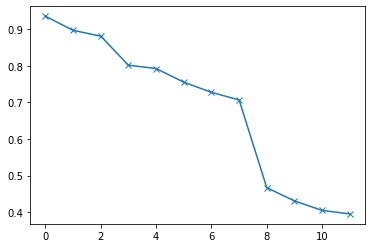

In [83]:
plt.plot(dq,'-x')

In [89]:
ix1 = np.logical_and(step4['time.year']>21,step4['time.year']<=31)
ix2 = np.logical_and(step4['time.year']>31,step4['time.year']<=41)
tec1 = step4.TOTECOSYSC.sel(ens=0).isel(time=ix1).mean(dim='time')
tec2 = step4.TOTECOSYSC.sel(ens=0).isel(time=ix2).mean(dim='time')
dtec = (tec2-tec1)/10
ixg  = abs(dtec)>1
diseq = landarea[ixg].sum()/landarea.sum()

Text(0.5, 0, 'gridcell')

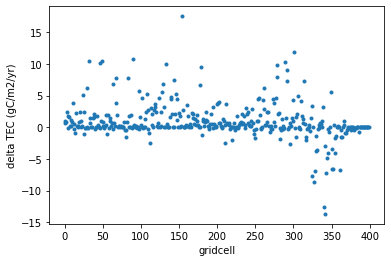

In [93]:
plt.plot(dtec,'.')
plt.ylabel('delta TEC (gC/m2/yr)')
plt.xlabel('gridcell')

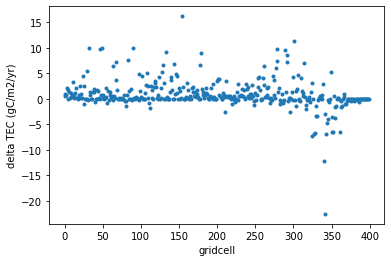

In [104]:
ix1 = step4['time.year']>31
tec1 = step4.TOTECOSYSC.sel(ens=0).isel(time=ix1).mean(dim='time')
mwts = month_wts(10)/365
tec2 = (mwts*ds.TOTECOSYSC).sel(ens=0).groupby('time.year').sum().mean(dim='year')
dtec = (tec2-tec1)/10
ixg  = abs(dtec)>1
diseq = landarea[ixg].sum()/landarea.sum()
plt.plot(dtec,'.')
plt.ylabel('delta TEC (gC/m2/yr)')
plt.xlabel('gridcell');

ValueError: 'time' not found in array dimensions ('year', 'gridcell')